In [1]:
pip install opencv-python

   ---------------------------------------- 0.0/39.5 MB ? eta -:--:--
   ---------------------------------------- 0.0/39.5 MB ? eta -:--:--
   ---------------------------------------- 0.0/39.5 MB ? eta -:--:--
   ---------------------------------------- 0.0/39.5 MB ? eta -:--:--
   ---------------------------------------- 0.0/39.5 MB ? eta -:--:--
   ---------------------------------------- 0.0/39.5 MB ? eta -:--:--
   ---------------------------------------- 0.0/39.5 MB ? eta -:--:--
   ---------------------------------------- 0.0/39.5 MB ? eta -:--:--
   ---------------------------------------- 0.0/39.5 MB ? eta -:--:--
   ---------------------------------------- 0.0/39.5 MB ? eta -:--:--
   ---------------------------------------- 0.1/39.5 MB 656.4 kB/s eta 0:01:01
   ---------------------------------------- 0.1/39.5 MB 656.4 kB/s eta 0:01:01
   ---------------------------------------- 0.1/39.5 MB 656.4 kB/s eta 0:01:01
   ---------------------------------------- 0.1/39.5 MB 381.3 k

In [8]:
# Cell 1: Imports and configuration
import os
import random
import numpy as np
import cv2
from PIL import Image
from collections import defaultdict
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Configuration parameters
BASE_DIR      = r"D:\data3888\file"
N_PER_SUB     = 100    # Number of samples to draw from each subfolder
TEST_RATIO    = 0.2    # Proportion of data to reserve for test set
IMG_SIZE      = (128, 128)
KNN_NEIGHBORS = 5

In [9]:
# Cell 2: Gather file paths by subfolder
paths_by_sub = defaultdict(list)
for sub in os.listdir(BASE_DIR):
    folder = os.path.join(BASE_DIR, sub)
    if not os.path.isdir(folder):
        continue
    for fn in os.listdir(folder):
        if fn.lower().endswith(".png") and not fn.startswith("._"):
            paths_by_sub[sub].append(os.path.join(folder, fn))

In [10]:
# Cell 3: Sample N_PER_SUB images from each subfolder
all_paths, all_subs = [], []
for sub, ps in paths_by_sub.items():
    if len(ps) < N_PER_SUB:
        raise RuntimeError(f"Not enough images in {sub}: need {N_PER_SUB}")
    selected = random.sample(ps, N_PER_SUB)
    all_paths.extend(selected)
    all_subs.extend([sub] * N_PER_SUB)

In [11]:
# Cell 4: Map subfolders to four groups and encode labels
mapping = {
    # Tumour group
    "Invasive_Tumor": "Tumour",
    "Prolif_Invasive_Tumor": "Tumour",
    "T_Cell_and_Tumor_Hybrid": "Tumour",
    # Immune group
    "CD4+_T_Cells": "Immune",
    "CD8+_T_Cells": "Immune",
    "B_Cells": "Immune",
    "Mast_Cells": "Immune",
    "Macrophages_1": "Immune",
    "Macrophages_2": "Immune",
    "LAMP3+_DCs": "Immune",
    "IRF7+_DCs": "Immune",
    # Stromal group
    "Stromal": "Stromal",
    "Stromal_and_T_Cell_Hybrid": "Stromal",
    "Perivascular-Like": "Stromal",
    # All others default to Other
}
group_labels = [mapping.get(sub, "Other") for sub in all_subs]
le = LabelEncoder()
y_all = le.fit_transform(group_labels)
print("Encoded classes:", dict(zip(le.classes_, le.transform(le.classes_))))

Encoded classes: {'Immune': 0, 'Other': 1, 'Stromal': 2, 'Tumour': 3}


In [12]:
# Cell 5: Perform stratified train-test split
Xtr_paths, Xte_paths, y_train, y_test = train_test_split(
    all_paths, y_all,
    test_size=TEST_RATIO,
    stratify=y_all,
    random_state=42
)
print(f"Training set size: {len(Xtr_paths)} images")
print(f"Test set size:     {len(Xte_paths)} images")

Training set size: 1600 images
Test set size:     400 images


In [13]:
# Cell 6: Load and resize images into arrays
def load_and_resize(path):
    img = Image.open(path).convert("RGB")
    return np.array(img.resize(IMG_SIZE))

X_train = np.stack([load_and_resize(p) for p in Xtr_paths], axis=0)
X_test  = np.stack([load_and_resize(p) for p in Xte_paths], axis=0)

In [14]:
# Cell 7: Define augmentation functions
def apply_blur(images):
    return np.array([cv2.GaussianBlur(img, (5,5), 0) for img in images])

def apply_stretch(images, factor=1.2):
    result = []
    for img in images:
        h, w, _ = img.shape
        nw = int(w * factor)
        stretched = cv2.resize(img, (nw, h))
        x = (nw - w) // 2
        result.append(stretched[:, x:x+w])
    return np.array(result)

def apply_greyscale(images):
    result = []
    for img in images:
        g = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        result.append(cv2.cvtColor(g, cv2.COLOR_GRAY2RGB))
    return np.array(result)

def apply_rotation(images, angle=15):
    result = []
    for img in images:
        h, w, _ = img.shape
        M = cv2.getRotationMatrix2D((w//2, h//2), angle, 1.0)
        result.append(cv2.warpAffine(img, M, (w, h), borderMode=cv2.BORDER_REFLECT))
    return np.array(result)

In [15]:
# Cell 8: Build flattened training sets for each augmentation
variants = {
    "Standard":   X_train.reshape(len(X_train), -1),
    "Blur":       apply_blur(X_train).reshape(len(X_train), -1),
    "Stretch":    apply_stretch(X_train).reshape(len(X_train), -1),
    "Greyscale":  apply_greyscale(X_train).reshape(len(X_train), -1),
    "Rotation":   apply_rotation(X_train).reshape(len(X_train), -1),
}

X_test_flat = X_test.reshape(len(X_test), -1)

In [16]:
# Cell 9: Train and evaluate KNN on each variant
results = []
for name, X_flat in variants.items():
    knn = KNeighborsClassifier(n_neighbors=KNN_NEIGHBORS)
    knn.fit(X_flat, y_train)
    y_pred = knn.predict(X_test_flat)
    acc = accuracy_score(y_test, y_pred)
    print(f"\n{name} Accuracy: {acc:.2%}")
    print(classification_report(y_test, y_pred, target_names=le.classes_, zero_division=0))
    results.append({
        "Augmentation": name,
        "Accuracy":     acc,
        "F1_weighted":  classification_report(
            y_test, y_pred, target_names=le.classes_, zero_division=0, output_dict=True
        )["weighted avg"]["f1-score"]
    })


Standard Accuracy: 34.50%
              precision    recall  f1-score   support

      Immune       0.40      0.36      0.38       160
       Other       0.34      0.53      0.42       120
     Stromal       0.23      0.20      0.21        60
      Tumour       0.24      0.07      0.10        60

    accuracy                           0.34       400
   macro avg       0.30      0.29      0.28       400
weighted avg       0.33      0.34      0.33       400


Blur Accuracy: 34.75%
              precision    recall  f1-score   support

      Immune       0.40      0.38      0.39       160
       Other       0.34      0.55      0.42       120
     Stromal       0.21      0.17      0.19        60
      Tumour       0.33      0.05      0.09        60

    accuracy                           0.35       400
   macro avg       0.32      0.29      0.27       400
weighted avg       0.34      0.35      0.32       400


Stretch Accuracy: 31.50%
              precision    recall  f1-score   support



KNN performance across augmentations:
  Augmentation  Accuracy  F1_weighted
0     Standard    0.3450     0.325349
1         Blur    0.3475     0.322276
2      Stretch    0.3150     0.294190
3    Greyscale    0.3050     0.291083
4     Rotation    0.3625     0.345865


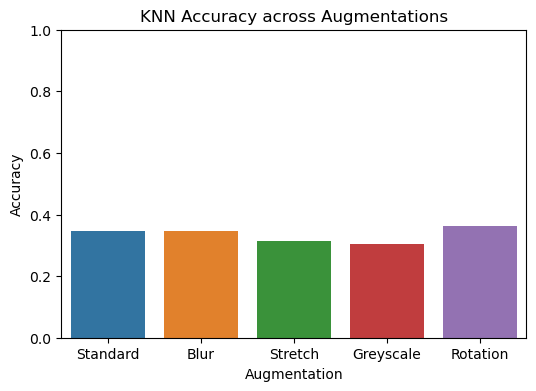

In [17]:
# Cell 10: Summarize and visualize results
df = pd.DataFrame(results)
print("\nKNN performance across augmentations:")
print(df)

plt.figure(figsize=(6,4))
sns.barplot(data=df, x="Augmentation", y="Accuracy")
plt.ylim(0,1)
plt.title("KNN Accuracy across Augmentations")
plt.show()